# Prediction model for diabetes dataset

This notebook assumes the use of the cleaned dataset (notebook EDA.ipynb).

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

import seaborn as sns



In [8]:
# Load dataset
data = pd.read_csv('../datasets/diabetes_cleaned.csv')


In [9]:
# Define target and features
target_feature = 'CLASS'
X = data.drop(columns=[target_feature])
y = data[target_feature]


In [10]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# print information regarding the splitted data
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
# Print the distribution of the target variable in the training set
print("\nDistribution of target variable in training set:")
print(y_train.value_counts(normalize=True)) # normalize=True gives the proportion of each class (value in 0~1)
# Print the distribution of the target variable in the testing set
print("\nDistribution of target variable in testing set:")
print(y_test.value_counts(normalize=True))

Training set size: 779
Testing set size: 195

Distribution of target variable in training set:
CLASS
1    0.894737
0    0.105263
Name: proportion, dtype: float64

Distribution of target variable in testing set:
CLASS
1    0.897436
0    0.102564
Name: proportion, dtype: float64


In [11]:
X_test

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
137,1,50.0,5.7,53.0,6.0,5.4,1.7,1.4,3.3,0.700000,25.0
837,1,42.0,2.3,52.0,7.0,5.2,2.8,3.1,1.3,0.900000,24.0
86,1,40.0,5.8,123.0,4.5,4.6,1.5,0.7,3.0,0.600000,24.0
395,0,60.0,6.2,87.0,4.8,4.8,1.6,0.8,1.2,0.500000,35.0
494,0,52.0,5.4,56.0,7.9,4.9,2.1,1.1,2.5,0.900000,28.0
...,...,...,...,...,...,...,...,...,...,...,...
655,0,59.0,5.2,56.0,10.9,4.9,2.1,1.1,2.5,0.900000,28.0
574,0,54.0,6.8,73.0,7.5,5.1,2.0,1.3,1.4,1.500000,39.0
182,0,38.0,4.0,67.0,10.2,5.2,2.0,1.1,3.2,0.905094,47.0
955,1,54.0,5.0,88.0,6.8,5.1,2.1,1.1,3.0,1.000000,30.0


In [12]:
y_test

137    1
837    1
86     0
395    1
494    1
      ..
655    1
574    1
182    1
955    1
896    1
Name: CLASS, Length: 195, dtype: int64

In [18]:
# Class balancing 

# Temp merge of X_train and y_train -> we need to merge them to perform undersampling
train_df = pd.concat([X_train, y_train], axis=1)

# 2 class division: divide the dataset into two classes based on the target variable
class_0 = train_df[train_df['CLASS'] == 0] # the rows with CLASS = 0
class_1 = train_df[train_df['CLASS'] == 1] # the rows with CLASS = 1

# Undersampling of class = '1' 
'''
class_1.sample(n=len(class_0), random_state=95)
.sample() is used to randomly select a specified number of rows from the DataFrame.
The n parameter specifies the number of rows to select how many rows to sample?)
We choose to balance the dataset equally so we sample the same number of rows as in class_0
'''
class_1_under = class_1.sample(n=len(class_0), random_state=95)

# Recombine the classes: re-merge class_0 and the undersampled class_1
train_balanced = pd.concat([class_0, class_1_under]) # concat class0 e class1 sottocampionato

# Shuffle
'''
This operation is commonly performed in machine learning after
operations like undersampling to ensure that similar 
class instances aren't clustered together, 
which helps prevent any potential bias during model training.

frac=1 means to shuffle all rows
.reset_index(drop=True) means to reset the index of the DataFrame after shuffling (remove old indexes and create ascending new ones)

'''
train_balanced = train_balanced.sample(frac=1, random_state=95).reset_index(drop=True) 


# Separation of features and target: since we need to train models, we separate again the target variable from the features
X_train_bal = train_balanced.drop(columns=['CLASS']) # train.balanced except the CLASS column
y_train_bal = train_balanced['CLASS']                # train.balanced CLASS column


# _________________________________________________
# BALANCED TRAINING DATASET NAMES:
# 
# - X_train_bal
# - y_train_bal
# 
# _______________________________________________________
# UNBALANCED TRAINING DATASET NAMES:
# 
# - X_train
# - y_train
# 
# ______________________________________________________
# TESTING DATASET NAMES: 
# !!! - must be the same for all models - !!!
# 
# - X_test
# - y_test
# 
# _______________________________________________________

In [ ]:
# print information regarding the splitted data after balancing
print("\nAfter balancing:")
print(f"Training set size: {X_train_bal.shape[0]}")
# Print the distribution of the target variable in the training set
print("\nDistribution of target variable in training set:")
print(y_train_bal.value_counts(normalize=True))



After balancing:
Training set size: 164

Distribution of target variable in training set:
CLASS
1    0.5
0    0.5
Name: proportion, dtype: float64


#### Summary of datasets after splitting and balancing 
- **X_train_bal**: Features of the training set after balancing  
- **y_train_bal**: Target variable of the training set after balancing  
- **X_test**: Features of the testing set  
- **y_test**: Target variable of the testing set


#### Classification algorithm to be compared:
- **Logistic Regression**: best for binary classification
- **Decision Tree**: good for interpretability and non-linear relationships
- **K-Nearest Neighbors**: good for non-linear relationships and local patterns
- **Random Forest**: good for handling large datasets and feature importance


In [20]:
# Models 

# random_state = 95 is set for reproducibility of results.

# Unbalanced:
log_reg =       LogisticRegression(max_iter=1000, random_state=95) 
decision_tree = DecisionTreeClassifier(random_state=95)
knn =           KNeighborsClassifier()
rnd_forest =    RandomForestClassifier(random_state=95)

# balanced:
bal_log_reg =       LogisticRegression(max_iter=1000, random_state=95) 
bal_decision_tree = DecisionTreeClassifier(random_state=95)
bal_knn =           KNeighborsClassifier()
bal_rnd_forest =    RandomForestClassifier(random_state=95)



In [21]:
# Training for UNBALANCED datasets:

# Logistic Regression
log_reg.fit(X_train, y_train)

# Decision Tree
decision_tree.fit(X_train, y_train)

# K-Nearest Neighbors
knn.fit(X_train, y_train)

# Random Forest
rnd_forest.fit(X_train, y_train)




# Training for BALANCED datasets:

# Logistic Regression
bal_log_reg.fit(X_train_bal, y_train_bal)

# Decision Tree
bal_decision_tree.fit(X_train_bal, y_train_bal)

# K-Nearest Neighbors
bal_knn.fit(X_train_bal, y_train_bal)

# Random Forest
bal_rnd_forest.fit(X_train_bal, y_train_bal)


RandomForestClassifier(random_state=95)

In [22]:
# Testing for UNBALANCED datasets:

# Logistic Regression
prediction_log_reg = log_reg.predict(X_test)

# Decision Tree
prediction_decision_tree = decision_tree.predict(X_test)

# K-Nearest Neighbors
prediction_knn = knn.predict(X_test)

# Random Forest
prediction_r_forest = rnd_forest.predict(X_test)



# Testing for BALANCED datasets:

# Logistic Regression
prediction_balanced_log_reg = bal_log_reg.predict(X_test)

# Decision Tree
prediction_balanced_decision_tree = bal_decision_tree.predict(X_test)

# K-Nearest Neighbors
prediction_balanced_knn = bal_knn.predict(X_test)

# Random Forest
prediction_balanced_r_forest = bal_rnd_forest.predict(X_test)



In [24]:
# Define the models and predictions
models = ['Logistic Regression',
          'Decision Tree',
          'K-Nearest Neighbors',
          'Random Forest'
          ]

# predictions for balanced datasets:
vector_prediction_balanced =    [prediction_balanced_log_reg,
                                 prediction_balanced_decision_tree,
                                 prediction_balanced_knn,
                                 prediction_balanced_r_forest
                                ]

# predictions for unbalanced datasets:
vector_prediction_unbalanced = [prediction_log_reg,
                                prediction_decision_tree,
                                prediction_knn,
                                prediction_r_forest
                                ]



# metrics calculation ---- BALANCED DATASETS ------------------------
# preparing empty lists to store the metrics
balanced_accuracy =     []
balanced_precision =    []
balanced_f1 =           []
balanced_recall_0 =     []
balanced_recall_1 =     []

for balanced_prediction in vector_prediction_balanced:
    balanced_accuracy.append(accuracy_score(y_test, balanced_prediction))
    balanced_precision.append(precision_score(y_test, balanced_prediction))
    balanced_f1.append(f1_score(y_test, balanced_prediction))
    balanced_recall_0.append(recall_score(y_test, balanced_prediction, pos_label=0))
    balanced_recall_1.append(recall_score(y_test, balanced_prediction, pos_label=1))


# Create dataframe for balanced metrics
balanced_metrics_df = pd.DataFrame({
    'Model':        models,
    'Accuracy':     balanced_accuracy,
    'Precision':    balanced_precision,
    'F1-Score':     balanced_f1,
    'Recall (0)':   balanced_recall_0,
    'Recall (1)':   balanced_recall_1
})



# metrics calculation ---- UNBALANCED DATASETS ---------------------
unbalanced_accuracy =   []
unbalanced_precision =  []
unbalanced_f1 =         []
unbalanced_recall_0 =   []
unbalanced_recall_1 =   []

for unbalanced_prediction in vector_prediction_unbalanced:
    unbalanced_accuracy.append(accuracy_score(y_test, unbalanced_prediction))
    unbalanced_precision.append(precision_score(y_test, unbalanced_prediction))
    unbalanced_f1.append(f1_score(y_test, unbalanced_prediction))
    unbalanced_recall_0.append(recall_score(y_test, unbalanced_prediction, pos_label=0))
    unbalanced_recall_1.append(recall_score(y_test, unbalanced_prediction, pos_label=1))

# Create dataframe for unbalanced metrics
unbalanced_metrics_df = pd.DataFrame({
    'Model':        models,
    'Accuracy':     unbalanced_accuracy,
    'Precision':    unbalanced_precision,
    'F1-Score':     unbalanced_f1,
    'Recall (0)':   unbalanced_recall_0,
    'Recall (1)':   unbalanced_recall_1
})

# Display the dataframes
print("Balanced Metrics:")
print(balanced_metrics_df)
print("_______________________\n")
print("\nUnbalanced Metrics:")
print(unbalanced_metrics_df)
print("_______________________\n")


Balanced Metrics:
                 Model  Accuracy  Precision  F1-Score  Recall (0)  Recall (1)
0  Logistic Regression  0.958974   0.994083  0.976744        0.95    0.960000
1        Decision Tree  0.994872   1.000000  0.997135        1.00    0.994286
2  K-Nearest Neighbors  0.871795   0.974684  0.924925        0.80    0.880000
3        Random Forest  0.984615   1.000000  0.991354        1.00    0.982857
_______________________


Unbalanced Metrics:
                 Model  Accuracy  Precision  F1-Score  Recall (0)  Recall (1)
0  Logistic Regression  0.958974   0.971751  0.977273        0.75    0.982857
1        Decision Tree  0.994872   0.994318  0.997151        0.95    1.000000
2  K-Nearest Neighbors  0.923077   0.934783  0.958217        0.40    0.982857
3        Random Forest  0.994872   0.994318  0.997151        0.95    1.000000
_______________________



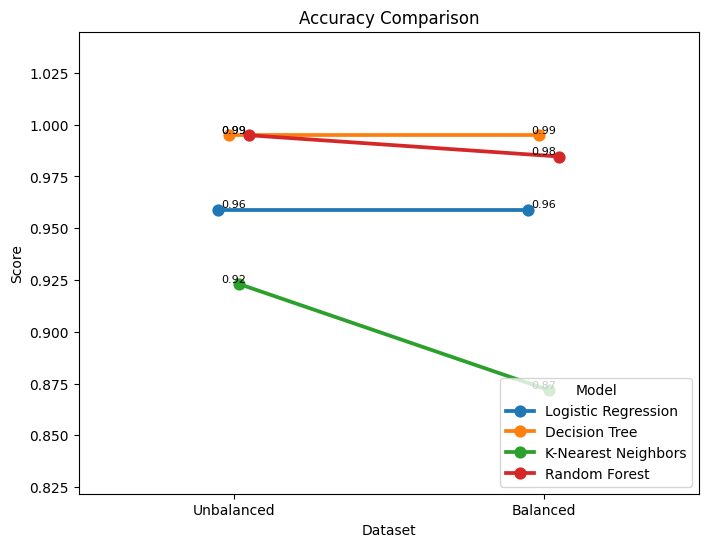

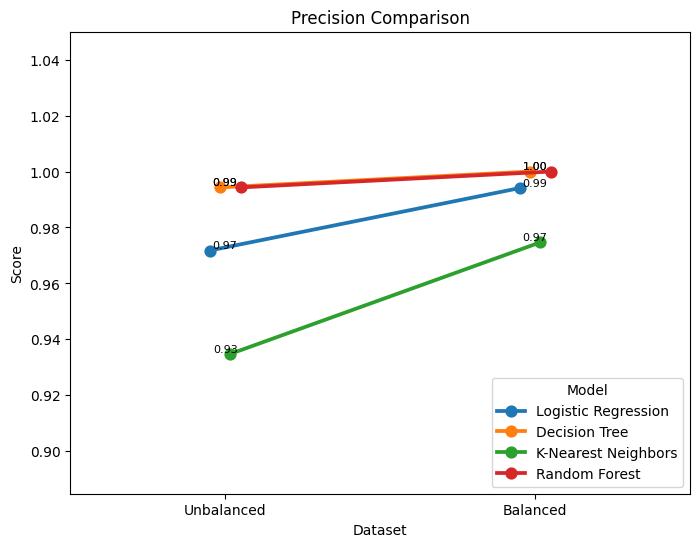

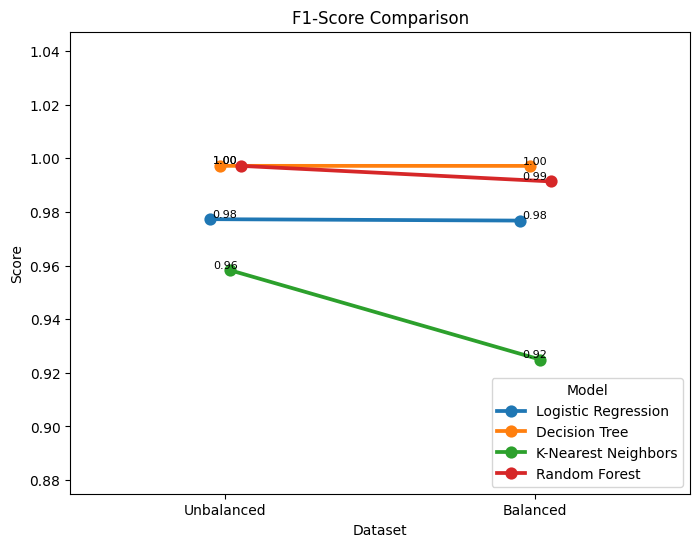

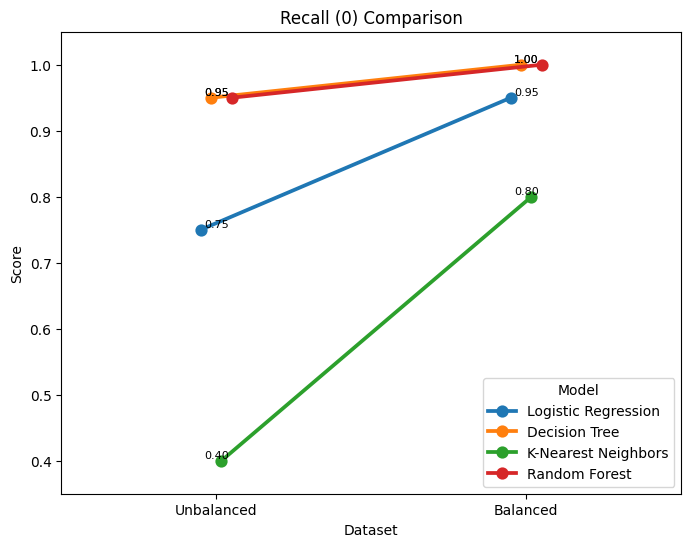

In [86]:
# Prepare data for plotting
metrics = ['Accuracy', 'Precision', 'F1-Score', 'Recall (0)']
plot_data = pd.melt(
    pd.concat([balanced_metrics_df.assign(Dataset='Balanced'), unbalanced_metrics_df.assign(Dataset='Unbalanced')]),
    id_vars=['Model', 'Dataset'],
    value_vars=metrics,
    var_name='Metric',
    value_name='Score'
)

# Create standalone plots for each metric
for metric in metrics:
    metric_data = plot_data[plot_data['Metric'] == metric]
    plt.figure(figsize=(8, 6))
    sns.pointplot(data=metric_data, x="Dataset", y="Score", hue="Model", order=['Unbalanced', 'Balanced'], dodge=True)
    plt.title(f"{metric} Comparison")
    
    # Dynamically set y-axis limits based on min and max values
    min_score = metric_data['Score'].min()
    max_score = metric_data['Score'].max()
    plt.ylim(min_score - 0.05, max_score + 0.05)  # Add some padding for better visualization
    
    plt.xlabel("Dataset")
    plt.ylabel("Score")
    plt.legend(title="Model", loc='lower right')
    
    # Annotate points with numeric values
    for index in range(len(metric_data)):
        x = metric_data.iloc[index]['Dataset']
        y = metric_data.iloc[index]['Score']
        plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=8)


    plt.show()


In [ ]:
# Plot the performance metrics for the balanced dataset
metrics = ['Accuracy', 'Precision', 'F1-Score', 'Recall (0)', 'Recall (1)']
x = np.arange(len(models))  # the label locations
bar_width = 0.15

fig, ax = plt.subplots(figsize=(10, 5))

# Plot bars for each metric
for i, metric in enumerate(metrics):
    ax.bar(x + i * bar_width, balanced_metrics_df[metric], bar_width, label=metric)

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics for Balanced Dataset')
ax.set_xticks(x + (len(metrics) - 1) * bar_width / 2)
ax.set_xticklabels(models, rotation=45)
ax.legend(loc='lower right')

# Annotate bars with values
for i, metric in enumerate(metrics):
    for j, value in enumerate(balanced_metrics_df[metric]):
        ax.annotate(f'{value:.2f}', xy=(j + i * bar_width, value),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
# Adjust the y-axis limit to leave some space above 1
ax.set_ylim(0, 1.1)

plt.show()

In [ ]:
# we will go on with only the balanced dataset since performance are improved

# Plot feature importance for Random Forest (balanced dataset)
feature_importances = bal_rnd_forest.feature_importances_
features = X_train_bal.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance (Random Forest - Balanced Dataset)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create subplots for unbalanced datasets
fig, axes = plt.subplots(1, len(models), figsize=(20, 5))
for ax, model, y_pred_unbal in zip(axes, models, vector_prediction_unbalanced):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_unbal, ax=ax, colorbar=False)
    ax.set_title(f"{model} (Unbalanced)")

plt.tight_layout()
plt.show()

# Create subplots for balanced datasets
fig, axes = plt.subplots(1, len(models), figsize=(20, 5))
for ax, model, y_pred_bal in zip(axes, models, vector_prediction_balanced):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_bal, ax=ax, colorbar=False)
    ax.set_title(f"{model} (Balanced)")

plt.tight_layout()
plt.show()
